Навчання TD3...
Навчання DDPG...
Навчання SAC...


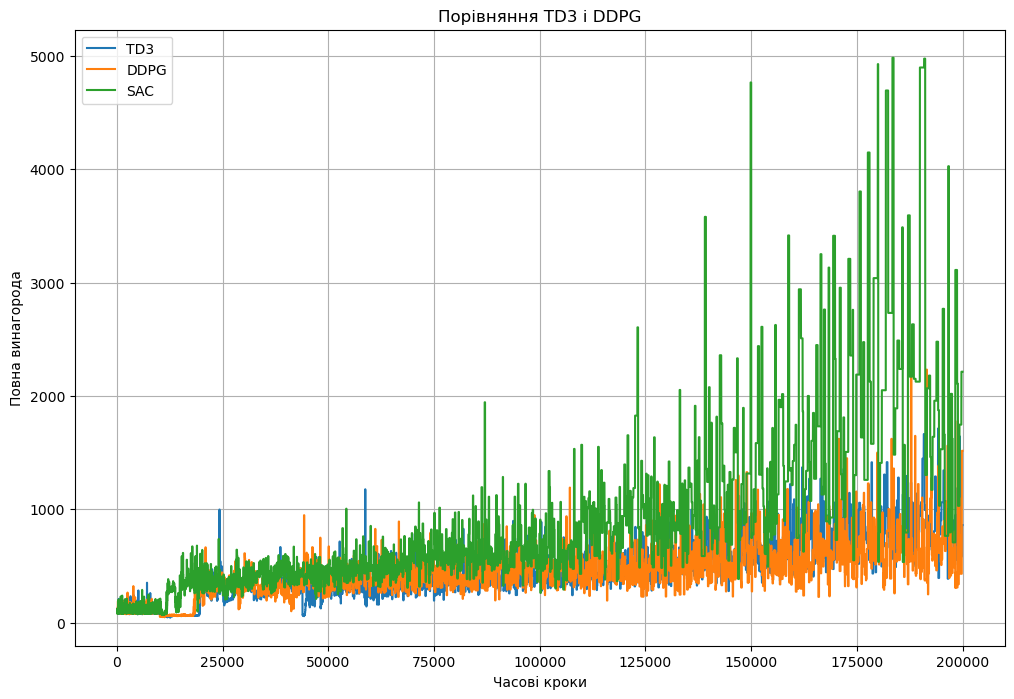

In [1]:
import gymnasium as gym
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# Клас для збору даних про винагороди
class RewardCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []
        self.timesteps = []
        
    def _on_step(self):
        if len(self.model.ep_info_buffer) > 0:
            self.rewards.append(self.model.ep_info_buffer[-1]["r"])
            self.timesteps.append(self.model.num_timesteps)
        return True

# Створюємо середовище
env = gym.make("Humanoid-v5")

# Визначаємо гіперпараметри TD3
n_actions = env.action_space.shape[0]

# Налаштування шуму для дослідження
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions)
)

# Створюємо TD3 модель
td3_model = TD3(
    "MlpPolicy",
    env,
    learning_rate=0.0003,          # Швидкість навчання актора
    learning_starts=10000,
    device='cuda',
    gradient_steps=1,
    batch_size=256,              # Розмір пакету
    action_noise=action_noise,    # Сигма (шум)
)

# Створюємо DDPG модель для порівняння
ddpg_model = DDPG(
    "MlpPolicy",
    env,
    learning_rate=0.0003,          # Швидкість навчання актора
    learning_starts=10000,
    device='cuda',
    gradient_steps=1,
    batch_size=256,              # Розмір пакету
    action_noise=action_noise, 
)

# Створюємо SAC модель
sac_model = SAC(
    "MlpPolicy",
    env,
    learning_rate=0.0003,          
    learning_starts=10000,         
    batch_size=256,                
    gradient_steps=1,              
    device='cuda',                 
    # SAC-специфічні параметри
    tau=0.005,                     # Коефіцієнт м'якого оновлення
    gamma=0.99,                    # Коефіцієнт знецінення
    train_freq=1,                  # Частота оновлення
    use_sde=False                  # Без використання State-Dependent Exploration
)

# Callbacks для збору даних
td3_callback = RewardCallback()
ddpg_callback = RewardCallback()
sac_callback = RewardCallback()

# Навчання моделей
print("Навчання TD3...")
td3_model.learn(total_timesteps=200000, callback=td3_callback)
print("Навчання DDPG...")
ddpg_model.learn(total_timesteps=200000, callback=ddpg_callback)
print("Навчання SAC...")
sac_model.learn(total_timesteps=200000, callback=sac_callback)

# Збереження моделей
td3_model.save("td3_humanoid")
ddpg_model.save("ddpg_humanoid")
sac_model.save("sac_humanoid")

# Візуалізація результатів
plt.figure(figsize=(12, 8))
plt.plot(td3_callback.timesteps, td3_callback.rewards, label='TD3')
plt.plot(ddpg_callback.timesteps, ddpg_callback.rewards, label='DDPG')
plt.plot(sac_callback.timesteps, sac_callback.rewards, label='SAC')
plt.xlabel('Часові кроки')
plt.ylabel('Повна винагорода')
plt.title('Порівняння TD3 і DDPG')
plt.legend()
plt.grid(True)
plt.savefig('comparison_plot.png')
plt.show()

In [3]:
# Тестування навченої моделі
env = gym.make("Humanoid-v5", render_mode="human")
obs, _ = env.reset()

for _ in range(1000):
    action, _ = sac_model.predict(obs, deterministic=True)
    obs, _, done, truncated, _ = env.step(action)
    if done or truncated:
        obs, _ = env.reset()

env.close()